In [3]:
import numpy as np 
from src import utils
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem
from IPython.display import clear_output
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
from matplotlib import rcParams
default_font = 12
fs_title = 16
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange', 'grey'] #rew #nrew #rew_test #nrew_test #GI

In [5]:
def get_dummy_vars(m1, lick_window=(150,250), onlytest=False):
    ntrials = m1.interp_spks.shape[1]
    rewarded = np.zeros(ntrials, dtype=bool)
    correct = np.zeros(ntrials, dtype=bool)
    rew_trials = np.concatenate((m1.trial_dict["rewarded"], m1.trial_dict["rewarded test"]))
    rewarded[rew_trials] = 1
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):
        rewarded_trials = ["rewarded", "rewarded test"]
        non_rewarded_trials = ["non rewarded", "non rewarded test"]
        if ttype in rewarded_trials:
            t_licks, _ = utils.get_trials_with_licks(m1, lick_window=lick_window, trialtype=ttype)
            correct[t_licks] = 1
        if ttype in non_rewarded_trials:
            _, t_no_licks = utils.get_trials_with_licks(m1, lick_window=lick_window, trialtype=ttype)
            correct[t_no_licks] = 1
    return rewarded, correct

def dprime_cell(m1, condition1, condition2, discrimination_region=(0,125), subpop=None):
    """
    Compute the d-prime for a single cell.
    """
    response = m1.interp_spks[:,:,discrimination_region[0]:discrimination_region[1]].mean(2)
    r1 = response[:, condition1]
    r2 = response[:, condition2]
    if subpop is not None:
        r1 = r1[subpop]
        r2 = r2[subpop]
    # collect means and stds
    mu1 = r1.mean(1)
    mu2 = r2.mean(1)
    std1 = r1.std(1) + np.finfo(np.float64).tiny
    std2 = r2.std(1) + np.finfo(np.float64).tiny
    #compute the train dprime
    dp = 2 * ((mu1 - mu2) / (std1 + std2))
    return dp

def dprime_pop(m1, subpop, condition1, condition2, discrimination_region=(0,125)):
    """
    Compute the d-prime for a population of cells.
    """
    response = m1.interp_spks[:,:,discrimination_region[0]:discrimination_region[1]].mean(2)
    response = response[subpop]
    if len(condition1) != len(condition2):
        # make sure the two conditions are the same length
        min_len = min(len(condition1), len(condition2))
        condition1 = condition1[:min_len]
        condition2 = condition2[:min_len]

    r1 = response[:, condition1]
    r2 = response[:, condition2]

    # collect means and stds
    mu1 = r1.mean(0)
    mu2 = r2.mean(0)
    cov = 0.5 * (np.cov(r1, rowvar=0) +  np.cov(r2, rowvar=0))
    w = np.linalg.inv(cov) @ (mu1 - mu2)
    w /= np.linalg.norm(w)
    proj1 = r1 @ w
    proj2 = r2 @ w
    dmean = np.abs(np.mean(proj1) - np.mean(proj2))
    dstd = np.sqrt(0.5 * (np.var(proj1) + np.var(proj2)))
    pop_dp = dmean / dstd
    return pop_dp

In [6]:
def build_correct_dicts(m, lick_window=(150,250), onlytest=False):
    """
    Build dictionaries of correct and incorrect trials for each trial type.
    """
    correct_dict = {}
    incorrect_dict = {}
    for ttype in ["rewarded", "non rewarded", "rewarded test", "non rewarded test"]:
        t_licks, t_nolicks = utils.get_trials_with_licks(m, lick_window=lick_window, trialtype=ttype, onlytest=onlytest)
        if ttype in ["rewarded", "rewarded test"]:
            correct_dict[ttype] = t_licks
            incorrect_dict[ttype] = t_nolicks
        if ttype in ["non rewarded", "non rewarded test"]:
            correct_dict[ttype] = t_nolicks
            incorrect_dict[ttype] = t_licks
    return correct_dict, incorrect_dict

# gain as global effect or feature / task related only

In [18]:
VG11 = []
VG11.append({'mname': 'VG11', 'datexp': '2024_10_31', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_14', 'blk':'2'})
VG14 = []
VG14.append({'mname': 'VG14', 'datexp': '2024_11_21', 'blk':'2'})
VG15 = []
VG15.append({'mname': 'VG15', 'datexp': '2024_10_31', 'blk':'2'})
behav_sess = VG11 + VG14 + VG15

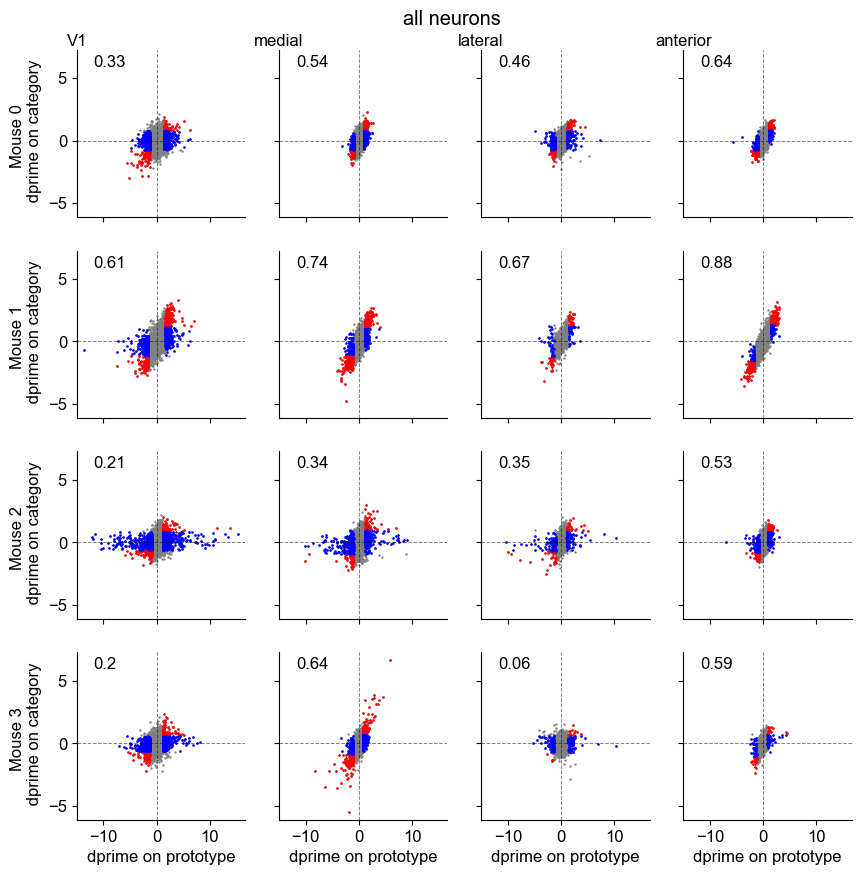

In [9]:
areas = ["V1", "medial", "lateral", "anterior"]
fig, ax = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True)
for iss, sess in enumerate(behav_sess):
    name, date, blk = sess['mname'], sess['datexp'], sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj\notz")
    ax[iss,0].set_ylabel(f'Mouse {iss} \n dprime on category')
    #selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
    correct_dict, incorrect_dict = build_correct_dicts(m1, lick_window=(150,250), onlytest=False)
    protA_train = np.intersect1d(m1.trial_dict["rewarded"][::2], correct_dict["rewarded"]) 
    protB_train = np.intersect1d(m1.trial_dict["non rewarded"][::2], correct_dict["non rewarded"])
    catA_train = np.intersect1d(m1.trial_dict["rewarded test"][::2], correct_dict["rewarded test"])
    catB_train = np.intersect1d(m1.trial_dict["non rewarded test"][::2], correct_dict["non rewarded test"])
    fig.suptitle("all neurons", y=0.92)
    for ia, area in enumerate(areas):
        a = utils.get_region_idx(m1.iarea, area)
        dp_prot = dprime_cell(m1, protA_train, protB_train, discrimination_region=(0,125), subpop= a) #a*selected_type
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dp_prot, tsh=95) 
        prefer_r = (dp_prot>=pstv_tsh)
        prefer_nr = (dp_prot<=ngtv_tsh)
        selective_neurons = prefer_r + prefer_nr
        selective_prot = selective_neurons
        dp_ontest = dprime_cell(m1, catA_train, catB_train, discrimination_region=(0,125), subpop= a)
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dp_ontest, tsh=95) 
        prefer_r_cat = (dp_ontest>=pstv_tsh)
        prefer_nr_cat = (dp_ontest<=ngtv_tsh)
        selective_cat = prefer_r_cat + prefer_nr_cat
        ax[iss,ia].scatter(dp_prot, dp_ontest, s=0.5, color='gray')
        ax[iss,ia].scatter(dp_prot[prefer_r*prefer_r_cat], dp_ontest[prefer_r*prefer_r_cat], s=0.7, color='red')
        ax[iss,ia].scatter(dp_prot[prefer_nr*prefer_nr_cat], dp_ontest[prefer_nr*prefer_nr_cat], s=0.7, color='red')
        ax[iss,ia].scatter(dp_prot[selective_prot*np.logical_not(selective_cat*selective_prot)], dp_ontest[selective_prot*np.logical_not(selective_cat*selective_prot)], s=0.7, color='blue')
        ax[iss,ia].axvline(x=0, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
        ax[iss,ia].axhline(y=0, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
        corr = np.corrcoef(dp_ontest, dp_prot)[0, 1]
        ax[iss,ia].text(0.1,.9, f"{np.round(corr, 2)}", fontsize=default_font, color='k', transform=ax[iss,ia].transAxes)
        if iss == 0:
            ax[iss,ia].set_title(f'{area}', ha='center', va="center", fontsize=default_font)
        if iss == 3:
            ax[iss,ia].set_xlabel('dprime on prototype')
        clear_output()

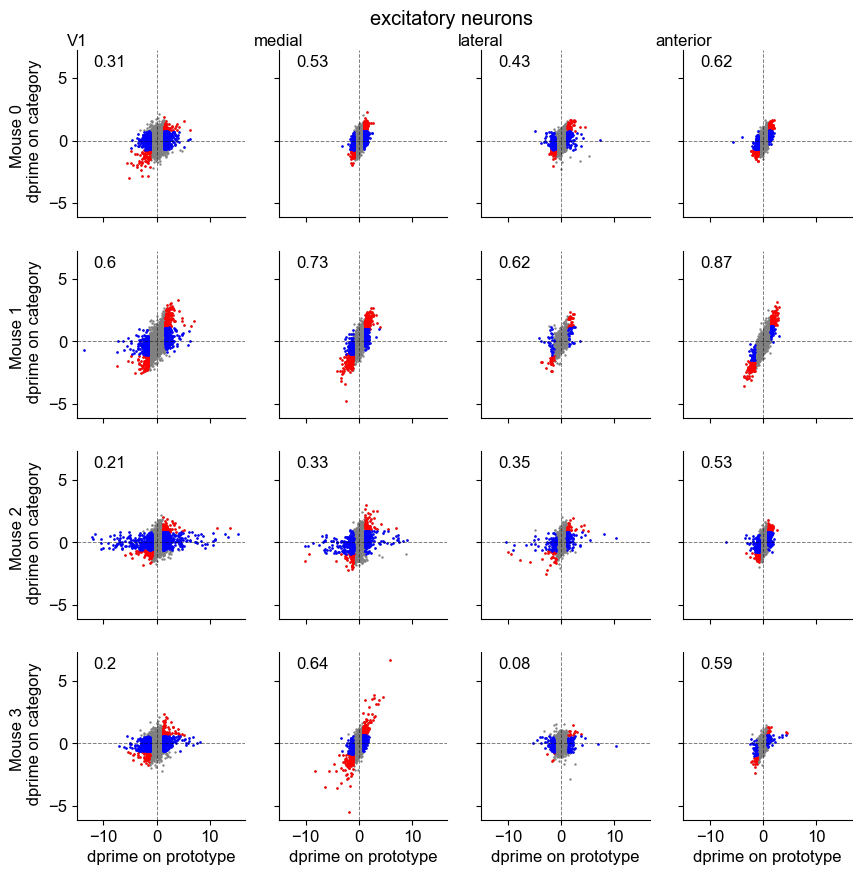

In [11]:
areas = ["V1", "medial", "lateral", "anterior"]
fig, ax = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True)
for iss, sess in enumerate(behav_sess):
    name, date, blk = sess['mname'], sess['datexp'], sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj\notz")
    ax[iss,0].set_ylabel(f'Mouse {iss} \n dprime on category')
    selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
    correct_dict, incorrect_dict = build_correct_dicts(m1, lick_window=(150,250), onlytest=False)
    protA_train = np.intersect1d(m1.trial_dict["rewarded"][::2], correct_dict["rewarded"]) 
    protB_train = np.intersect1d(m1.trial_dict["non rewarded"][::2], correct_dict["non rewarded"])
    catA_train = np.intersect1d(m1.trial_dict["rewarded test"][::2], correct_dict["rewarded test"])
    catB_train = np.intersect1d(m1.trial_dict["non rewarded test"][::2], correct_dict["non rewarded test"])
    fig.suptitle("excitatory neurons", y=0.92)
    for ia, area in enumerate(areas):
        a = utils.get_region_idx(m1.iarea, area)
        dp_prot = dprime_cell(m1, protA_train, protB_train, discrimination_region=(0,125), subpop= a*selected_type) #a*selected_type
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dp_prot, tsh=95) 
        prefer_r = (dp_prot>=pstv_tsh)
        prefer_nr = (dp_prot<=ngtv_tsh)
        selective_neurons = prefer_r + prefer_nr
        selective_prot = selective_neurons
        dp_ontest = dprime_cell(m1, catA_train, catB_train, discrimination_region=(0,125), subpop= a*selected_type)
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dp_ontest, tsh=95) 
        prefer_r_cat = (dp_ontest>=pstv_tsh)
        prefer_nr_cat = (dp_ontest<=ngtv_tsh)
        selective_cat = prefer_r_cat + prefer_nr_cat
        ax[iss,ia].scatter(dp_prot, dp_ontest, s=0.5, color='gray')
        ax[iss,ia].scatter(dp_prot[prefer_r*prefer_r_cat], dp_ontest[prefer_r*prefer_r_cat], s=0.7, color='red')
        ax[iss,ia].scatter(dp_prot[prefer_nr*prefer_nr_cat], dp_ontest[prefer_nr*prefer_nr_cat], s=0.7, color='red')
        ax[iss,ia].scatter(dp_prot[selective_prot*np.logical_not(selective_cat*selective_prot)], dp_ontest[selective_prot*np.logical_not(selective_cat*selective_prot)], s=0.7, color='blue')
        ax[iss,ia].axvline(x=0, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
        ax[iss,ia].axhline(y=0, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
        corr = np.corrcoef(dp_ontest, dp_prot)[0, 1]
        ax[iss,ia].text(0.1,.9, f"{np.round(corr, 2)}", fontsize=default_font, color='k', transform=ax[iss,ia].transAxes)
        if iss == 0:
            ax[iss,ia].set_title(f'{area}', ha='center', va="center", fontsize=default_font)
        if iss == 3:
            ax[iss,ia].set_xlabel('dprime on prototype')
        clear_output()

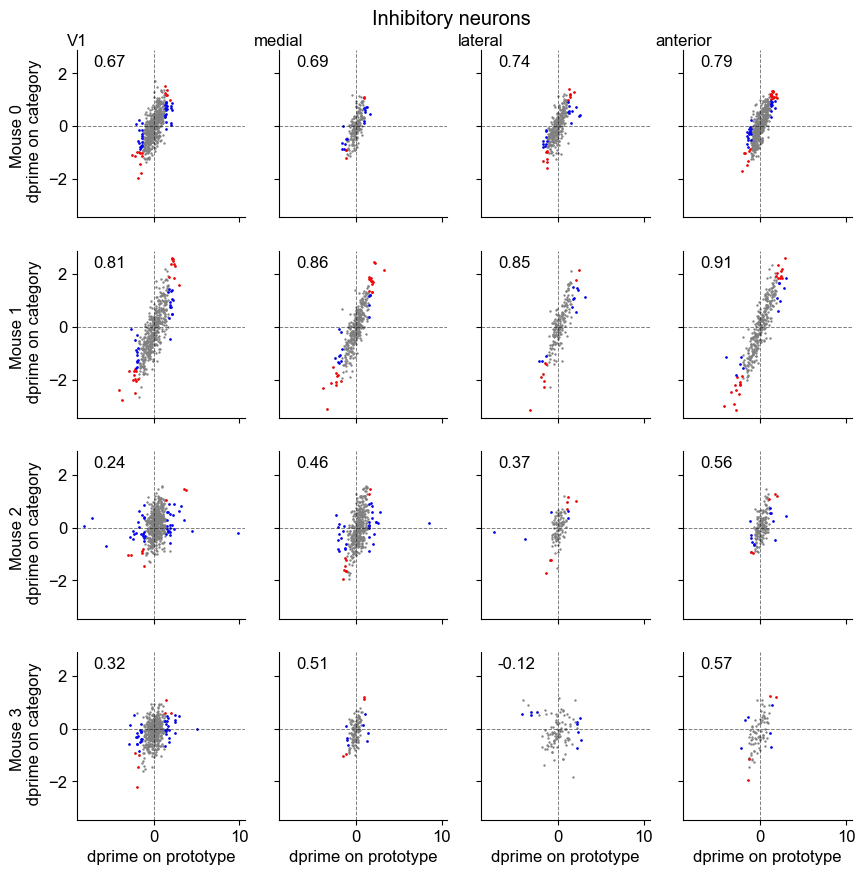

In [10]:
areas = ["V1", "medial", "lateral", "anterior"]
fig, ax = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True)
for iss, sess in enumerate(behav_sess):
    name, date, blk = sess['mname'], sess['datexp'], sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj\notz")
    ax[iss,0].set_ylabel(f'Mouse {iss} \n dprime on category')
    selected_type = m1.isred[:,0].astype(bool)
    correct_dict, incorrect_dict = build_correct_dicts(m1, lick_window=(150,250), onlytest=False)
    protA_train = np.intersect1d(m1.trial_dict["rewarded"][::2], correct_dict["rewarded"]) 
    protB_train = np.intersect1d(m1.trial_dict["non rewarded"][::2], correct_dict["non rewarded"])
    catA_train = np.intersect1d(m1.trial_dict["rewarded test"][::2], correct_dict["rewarded test"])
    catB_train = np.intersect1d(m1.trial_dict["non rewarded test"][::2], correct_dict["non rewarded test"])
    fig.suptitle("Inhibitory neurons", y=0.92)
    for ia, area in enumerate(areas):
        a = utils.get_region_idx(m1.iarea, area)
        dp_prot = dprime_cell(m1, protA_train, protB_train, discrimination_region=(0,125), subpop= a*selected_type) #a*selected_type
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dp_prot, tsh=95) 
        prefer_r = (dp_prot>=pstv_tsh)
        prefer_nr = (dp_prot<=ngtv_tsh)
        selective_neurons = prefer_r + prefer_nr
        selective_prot = selective_neurons
        dp_ontest = dprime_cell(m1, catA_train, catB_train, discrimination_region=(0,125), subpop= a*selected_type)
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dp_ontest, tsh=95) 
        prefer_r_cat = (dp_ontest>=pstv_tsh)
        prefer_nr_cat = (dp_ontest<=ngtv_tsh)
        selective_cat = prefer_r_cat + prefer_nr_cat
        ax[iss,ia].scatter(dp_prot, dp_ontest, s=0.5, color='gray')
        ax[iss,ia].scatter(dp_prot[prefer_r*prefer_r_cat], dp_ontest[prefer_r*prefer_r_cat], s=0.7, color='red')
        ax[iss,ia].scatter(dp_prot[prefer_nr*prefer_nr_cat], dp_ontest[prefer_nr*prefer_nr_cat], s=0.7, color='red')
        ax[iss,ia].scatter(dp_prot[selective_prot*np.logical_not(selective_cat*selective_prot)], dp_ontest[selective_prot*np.logical_not(selective_cat*selective_prot)], s=0.7, color='blue')
        ax[iss,ia].axvline(x=0, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
        ax[iss,ia].axhline(y=0, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
        corr = np.corrcoef(dp_ontest, dp_prot)[0, 1]
        ax[iss,ia].text(0.1,.9, f"{np.round(corr, 2)}", fontsize=default_font, color='k', transform=ax[iss,ia].transAxes)
        if iss == 0:
            ax[iss,ia].set_title(f'{area}', ha='center', va="center", fontsize=default_font)
        if iss == 3:
            ax[iss,ia].set_xlabel('dprime on prototype')
        clear_output()

In [12]:
#pop_responses_mice = np.empty((4, len(areas), 4, 4, 2, 500)) # mice, area, trial type, pop_selectivity, cell type, position
pop_responses_mice = np.empty((4, len(areas), 4, 4, 500)) # mice, area, trial type, pop_selectivity, cell type, position
for iss, sess in enumerate(behav_sess):
    name, date, blk = sess['mname'], sess['datexp'], sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj\notz")
    ### Crossvalidation partitions ###
    correct_dict, incorrect_dict = build_correct_dicts(m1, lick_window=(150,250), onlytest=False) #using all the trials
    ## Dprime selection trials
    protA_train = np.intersect1d(m1.trial_dict["rewarded"][::2], correct_dict["rewarded"]) 
    protB_train = np.intersect1d(m1.trial_dict["non rewarded"][::2], correct_dict["non rewarded"])
    catA_train = np.intersect1d(m1.trial_dict["rewarded test"][::2], correct_dict["rewarded test"])
    catB_train = np.intersect1d(m1.trial_dict["non rewarded test"][::2], correct_dict["non rewarded test"])
    
    ## test trials
    correct_rew_plot = np.intersect1d(m1.trial_dict["rewarded"][1::2], correct_dict["rewarded"])
    correct_nrew_plot = np.intersect1d(m1.trial_dict["non rewarded"][1::2], correct_dict["non rewarded"])
    correct_rewtest_plot = np.intersect1d(m1.trial_dict["rewarded test"][1::2], correct_dict["rewarded test"])
    correct_nrewtest_plot = np.intersect1d(m1.trial_dict["non rewarded test"][1::2], correct_dict["non rewarded test"])
    # Construct behavioral trials
    cr = np.concatenate((correct_rew_plot, correct_rewtest_plot))
    iom = np.concatenate((incorrect_dict["rewarded"],incorrect_dict["rewarded test"]))
    co = np.concatenate((correct_nrew_plot,correct_nrewtest_plot))
    fa = np.concatenate((incorrect_dict["non rewarded"],incorrect_dict["non rewarded test"]))
    # ommit the first trial 
    for t in [cr, iom, co, fa]:
        t = t[t != 0]
    print(f"TEST TRIALS: R correct: {len(cr)}", f"R incorrect: {len(iom)}", f"NR correct: {len(co)}", f"NR incorrect: {len(fa)}")
    between_intertrials = np.empty((m1.interp_spks.shape[0], m1.interp_spks.shape[1], m1.interp_spks.shape[2] + 100))
    ## gets the trial, with pre a post intertrial periods
    for i in range(between_intertrials.shape[1]):
        if i == 0: # just to keep shape consistency this trial is ignored
            between_intertrials[:, i, :100] = np.zeros((m1.interp_spks.shape[0], 100))
            between_intertrials[:, i, 100:] = m1.interp_spks[:, i, :]
        else:
            between_intertrials[:, i, :100] = m1.interp_spks[:, i-1,300:400]
            between_intertrials[:, i, 100:] = m1.interp_spks[:, i, :]
    #for type in range(2):
    #    if type == 0:
    #        selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
    #    else:
    #        selected_type = m1.isred[:,0].astype(bool)
    for ia, area in enumerate(areas):
        a = utils.get_region_idx(m1.iarea, area)
        dp_prot = dprime_cell(m1, protA_train, protB_train, discrimination_region=(0,125), subpop= a) #a*selected_type
        pop_response = between_intertrials[a] #a*selected_type
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dp_prot, tsh=95) 
        prefer_r = (dp_prot>=pstv_tsh)
        prefer_nr = (dp_prot<=ngtv_tsh)
        dp_ontest = dprime_cell(m1, catA_train, catB_train, discrimination_region=(0,125), subpop= a) #a*selected_type
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dp_ontest, tsh=95) 
        prefer_r_cat = (dp_ontest>=pstv_tsh)
        prefer_nr_cat = (dp_ontest<=ngtv_tsh)
        a_selective = prefer_r*prefer_r_cat
        b_selective = prefer_nr*prefer_nr_cat
        prot_A_selective_responses = prefer_r*np.logical_not(prefer_r_cat)
        prot_B_selective_responses = prefer_nr*np.logical_not(prefer_nr_cat)
        print(f"{area}" , f"Cat A selective: {np.sum(a_selective)}", f"Cat B selective: {np.sum(b_selective)}", f"Prot A selective: {np.sum(prot_A_selective_responses)}", f"Prot B selective: {np.sum(prot_B_selective_responses)}")
        for isel, selective in enumerate([a_selective, b_selective, prot_A_selective_responses, prot_B_selective_responses]):
            sel_response = pop_response[selective].mean(0)
            for it, trials in enumerate([cr, iom, co, fa]):
                trial_response = sel_response[trials].mean(0) 
                #pop_responses_mice[iss,ia,it,isel,type] = trial_response
                pop_responses_mice[iss,ia,it,isel] = trial_response

Checking if model object exists ...
Loading mouse object from D:\mouseobj\notz\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'trial_dict', 'interp_spks', 'train_dp'])
TEST TRIALS: R correct: 54 R incorrect: 22 NR correct: 47 NR incorrect: 32
V1 Cat A selective: 85 Cat B selective: 98 Prot A selective: 436 Prot B selective: 423
medial Cat A selective: 111 Cat B selective: 100 Prot A selective: 276 Prot B selective: 287
lateral Cat A selective: 62 Cat B selective: 43 Prot A selective: 116 Prot B selective: 135
anterior Cat A selective: 148 Cat B selective: 88 Prot A selective: 167 Prot B selective: 227
Checking if model object exists ...
Loading mouse object from D:\mouseobj\notz\VG11\2024_11_14\2
Existing mouse object has

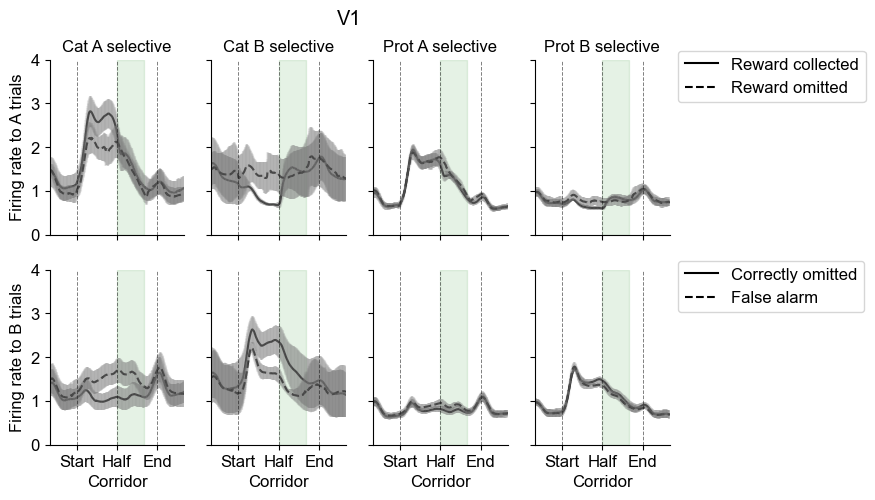

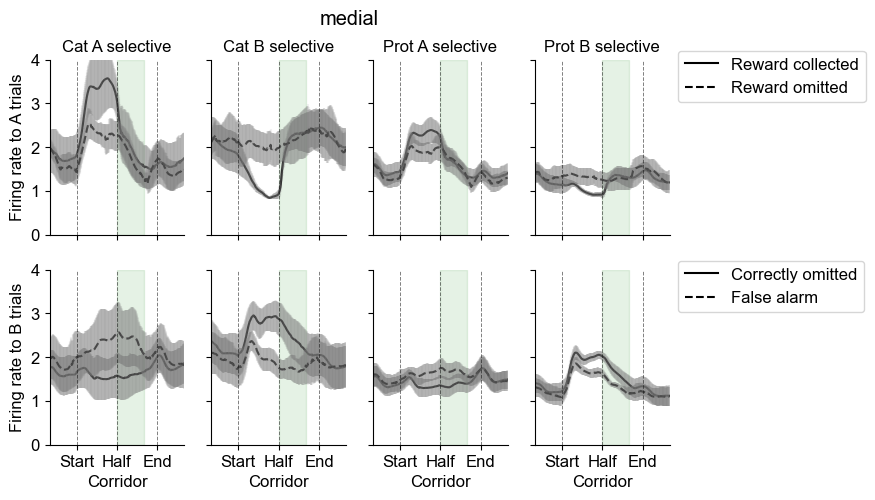

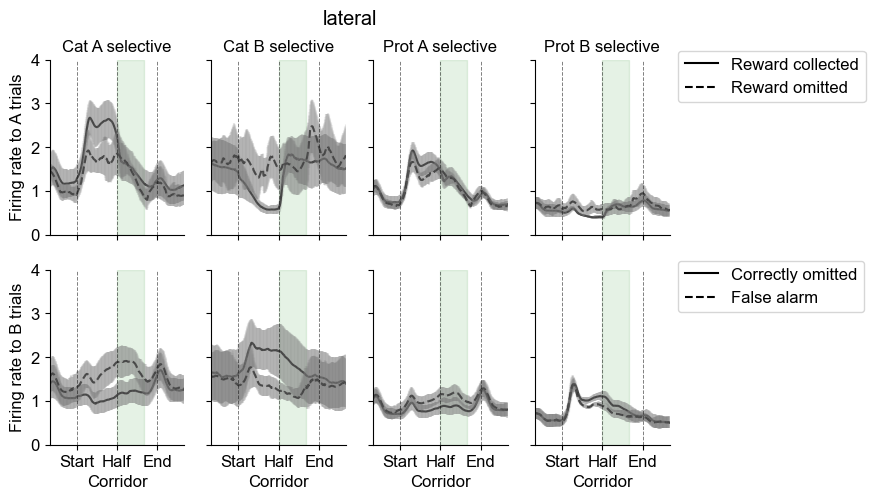

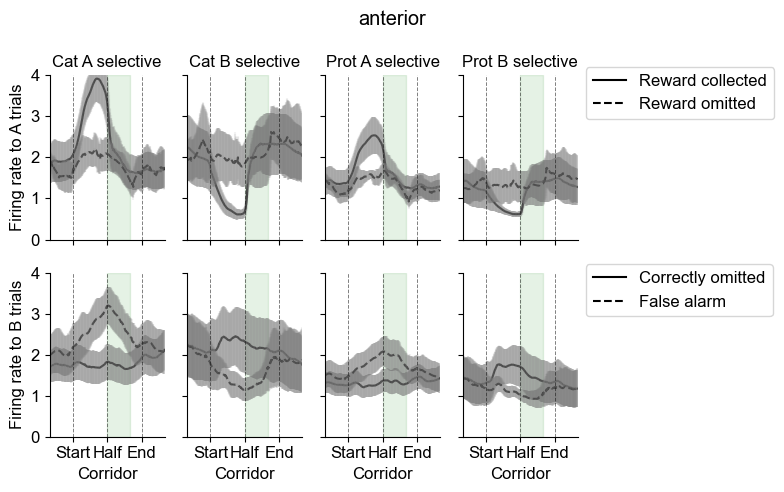

In [13]:
titles = ['Cat A selective', 'Cat B selective', 'Prot A selective', 'Prot B selective']
excitatory_res = pop_responses_mice
mean_mice = excitatory_res.mean(0)
sem_mice = sem(excitatory_res, axis=0)
for area in range(4):
    fig, ax = plt.subplots(2, 4, figsize=(8, 5), sharey=True, sharex=True)
    fig.suptitle(f'{areas[area]}', y=0.98)
    ax[0,0].set_ylabel('Firing rate to A trials', rotation=90)
    ax[1,0].set_ylabel('Firing rate to B trials', rotation=90)
    for sel in range(4):
        ax[0,sel].set_title(f'{titles[sel]}', loc='center', fontsize=default_font)
        for ttype in range(4):
            if ttype==0:
                ax[0,sel].plot(mean_mice[area,ttype,sel,:], color='k', linestyle='-', label = "Reward collected")
                ax[0,sel].errorbar(np.arange(500), mean_mice[area,ttype,sel,:], yerr=sem_mice[area,ttype,sel,:], color="gray", linestyle='-', alpha = 0.1)
            if ttype==1:
                ax[0,sel].plot(mean_mice[area,ttype,sel,:], color='k', linestyle='--', label = "Reward omitted")
                ax[0,sel].errorbar(np.arange(500), mean_mice[area,ttype,sel,:], yerr=sem_mice[area,ttype,sel,:], color="gray", linestyle='-', alpha = 0.1)
            if ttype==2:
                ax[1,sel].plot(mean_mice[area,ttype,sel,:], color='k', linestyle='-', label = "Correctly omitted")
                ax[1,sel].errorbar(np.arange(500), mean_mice[area,ttype,sel,:], yerr=sem_mice[area,ttype,sel,:], color="gray", linestyle='-', alpha = 0.1)
            if ttype==3:
                ax[1,sel].plot(mean_mice[area,ttype,sel,:], color='k', linestyle='--', label = "False alarm")
                ax[1,sel].errorbar(np.arange(500), mean_mice[area,ttype,sel,:], yerr=sem_mice[area,ttype,sel,:], color="gray", linestyle='-', alpha = 0.1)
    ax[0,-1].legend(bbox_to_anchor=(1., 1.1), loc='upper left')
    ax[1,-1].legend(bbox_to_anchor=(1., 1.1), loc='upper left')
    for p in range(4):
        ax[1,p].set_xlabel('Corridor')
        ax[1,p].set_xticks([100, 250, 400], labels=["Start", "Half", "End"])
        for i in range(2):
            ax[i,p].axvline(x=0, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
            ax[i,p].axvline(x=100, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
            ax[i,p].axvline(x=250, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
            ax[i,p].axvline(x=400, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
            ax[i,p].fill_betweenx([0, 4], 250, 350, color='green', alpha=0.1)
            ax[i,p].set_xlim(0, 500)
            ax[i,p].set_ylim(0, 4)
plt.tight_layout()

## first day training

Here I cannot split by "Correct trials" since the mouse has not been trained yet

In [1]:
VG11 = []
VG11.append({'mname': 'VG11', 'datexp': '2024_10_16', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_05', 'blk':'3'})
VG14 = []
VG14.append({'mname': 'VG14', 'datexp': '2024_10_16', 'blk':'2'})
VG15 = []
VG15.append({'mname': 'VG15', 'datexp': '2024_10_16', 'blk':'2'})
first_training = VG11 + VG14 + VG15

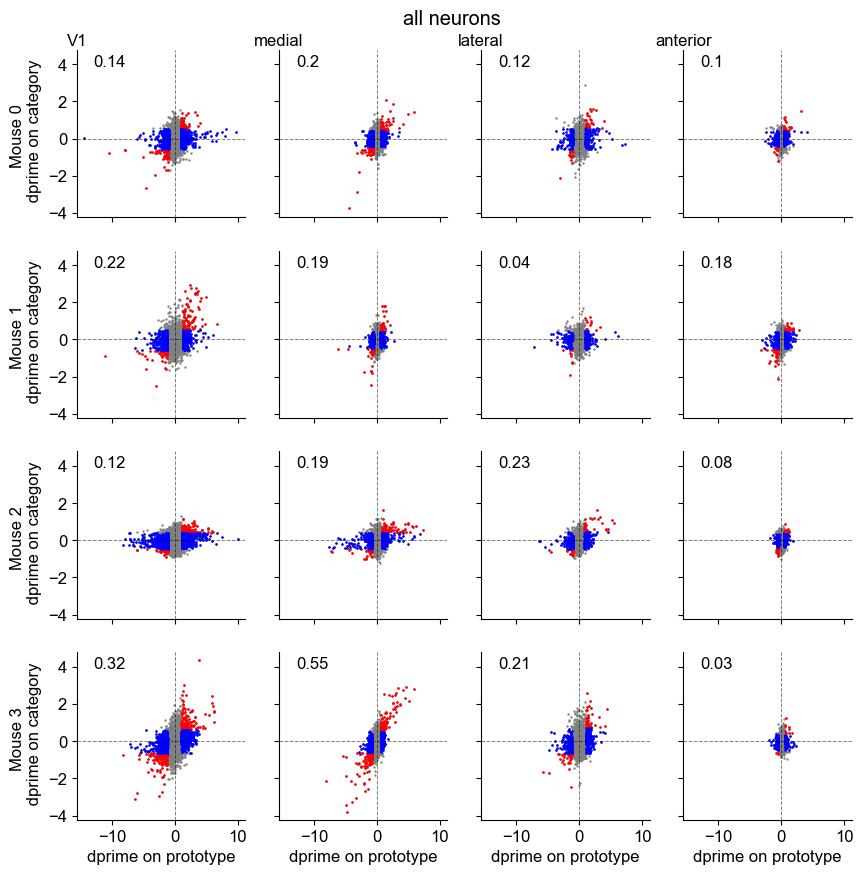

In [8]:
fig, ax = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True)
areas = ["V1", "medial", "lateral", "anterior"]
for iss, sess in enumerate(first_training):
    name, date, blk = sess['mname'], sess['datexp'], sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj\notz")
    ax[iss,0].set_ylabel(f'Mouse {iss} \n dprime on category')
    #selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
    correct_dict, incorrect_dict = build_correct_dicts(m1, lick_window=(150,250), onlytest=False)
    protA_train = m1.trial_dict["rewarded"][::2]
    protB_train = m1.trial_dict["non rewarded"][::2]
    catA_train = m1.trial_dict["rewarded test"][::2]
    catB_train = m1.trial_dict["non rewarded test"][::2]
    fig.suptitle("all neurons", y=0.92)
    for ia, area in enumerate(areas):
        a = utils.get_region_idx(m1.iarea, area)
        dp_prot = dprime_cell(m1, protA_train, protB_train, discrimination_region=(0,125), subpop= a) #a*selected_type
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dp_prot, tsh=95) 
        prefer_r = (dp_prot>=pstv_tsh)
        prefer_nr = (dp_prot<=ngtv_tsh)
        selective_neurons = prefer_r + prefer_nr
        selective_prot = selective_neurons
        dp_ontest = dprime_cell(m1, catA_train, catB_train, discrimination_region=(0,125), subpop= a)
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dp_ontest, tsh=95) 
        prefer_r_cat = (dp_ontest>=pstv_tsh)
        prefer_nr_cat = (dp_ontest<=ngtv_tsh)
        selective_cat = prefer_r_cat + prefer_nr_cat
        ax[iss,ia].scatter(dp_prot, dp_ontest, s=0.5, color='gray')
        ax[iss,ia].scatter(dp_prot[prefer_r*prefer_r_cat], dp_ontest[prefer_r*prefer_r_cat], s=0.7, color='red')
        ax[iss,ia].scatter(dp_prot[prefer_nr*prefer_nr_cat], dp_ontest[prefer_nr*prefer_nr_cat], s=0.7, color='red')
        ax[iss,ia].scatter(dp_prot[selective_prot*np.logical_not(selective_cat*selective_prot)], dp_ontest[selective_prot*np.logical_not(selective_cat*selective_prot)], s=0.7, color='blue')
        ax[iss,ia].axvline(x=0, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
        ax[iss,ia].axhline(y=0, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
        corr = np.corrcoef(dp_ontest, dp_prot)[0, 1]
        ax[iss,ia].text(0.1,.9, f"{np.round(corr, 2)}", fontsize=default_font, color='k', transform=ax[iss,ia].transAxes)
        if iss == 0:
            ax[iss,ia].set_title(f'{area}', ha='center', va="center", fontsize=default_font)
        if iss == 3:
            ax[iss,ia].set_xlabel('dprime on prototype')
        clear_output()

In [15]:
pop_responses_mice = np.empty((4, len(areas), 4, 4, 500)) # mice, area, trial type, pop_selectivity, cell type, position
for iss, sess in enumerate(first_training):
    name, date, blk = sess['mname'], sess['datexp'], sess['blk']
    m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj\notz")
    ### Crossvalidation partitions ###
    ## Dprime selection trials
    protA_train = m1.trial_dict["rewarded"][::2]
    protB_train = m1.trial_dict["non rewarded"][::2]
    catA_train = m1.trial_dict["rewarded test"][::2]
    catB_train = m1.trial_dict["non rewarded test"][::2]
    
    ## test trials
    rew_plot = m1.trial_dict["rewarded"][1::2]
    nrew_plot = m1.trial_dict["non rewarded"][1::2]
    rewtest_plot = m1.trial_dict["rewarded test"][1::2]
    nrewtest_plot = m1.trial_dict["non rewarded test"][1::2]
    # ommit the first trial 
    for t in [rew_plot, nrew_plot, rewtest_plot, nrewtest_plot]:
        t = t[t != 0]
    between_intertrials = np.empty((m1.interp_spks.shape[0], m1.interp_spks.shape[1], m1.interp_spks.shape[2] + 100))
    ## gets the trial, with pre a post intertrial periods
    for i in range(between_intertrials.shape[1]):
        if i == 0: # just to keep shape consistency this trial is ignored
            between_intertrials[:, i, :100] = np.zeros((m1.interp_spks.shape[0], 100))
            between_intertrials[:, i, 100:] = m1.interp_spks[:, i, :]
        else:
            between_intertrials[:, i, :100] = m1.interp_spks[:, i-1,300:400]
            between_intertrials[:, i, 100:] = m1.interp_spks[:, i, :]
    #for type in range(2):
    #    if type == 0:
    #        selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
    #    else:
    #        selected_type = m1.isred[:,0].astype(bool)
    for ia, area in enumerate(areas):
        a = utils.get_region_idx(m1.iarea, area)
        dp_prot = dprime_cell(m1, protA_train, protB_train, discrimination_region=(0,125), subpop= a) #a*selected_type
        pop_response = between_intertrials[a] #a*selected_type
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dp_prot, tsh=95) 
        prefer_r = (dp_prot>=pstv_tsh)
        prefer_nr = (dp_prot<=ngtv_tsh)
        dp_ontest = dprime_cell(m1, catA_train, catB_train, discrimination_region=(0,125), subpop= a) #a*selected_type
        pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(dp_ontest, tsh=95) 
        prefer_r_cat = (dp_ontest>=pstv_tsh)
        prefer_nr_cat = (dp_ontest<=ngtv_tsh)
        a_selective = prefer_r*prefer_r_cat
        b_selective = prefer_nr*prefer_nr_cat
        prot_A_selective_responses = prefer_r*np.logical_not(prefer_r_cat)
        prot_B_selective_responses = prefer_nr*np.logical_not(prefer_nr_cat)
        print(f"{area}" , f"Cat A selective: {np.sum(a_selective)}", f"Cat B selective: {np.sum(b_selective)}", f"Prot A selective: {np.sum(prot_A_selective_responses)}", f"Prot B selective: {np.sum(prot_B_selective_responses)}")
        for isel, selective in enumerate([a_selective, b_selective, prot_A_selective_responses, prot_B_selective_responses]):
            sel_response = pop_response[selective].mean(0)
            for it, trials in enumerate([rewtest_plot, nrewtest_plot, rew_plot, nrew_plot]):
                trial_response = sel_response[trials].mean(0) 
                #pop_responses_mice[iss,ia,it,isel,type] = trial_response
                pop_responses_mice[iss,ia,it,isel] = trial_response
    clear_output()

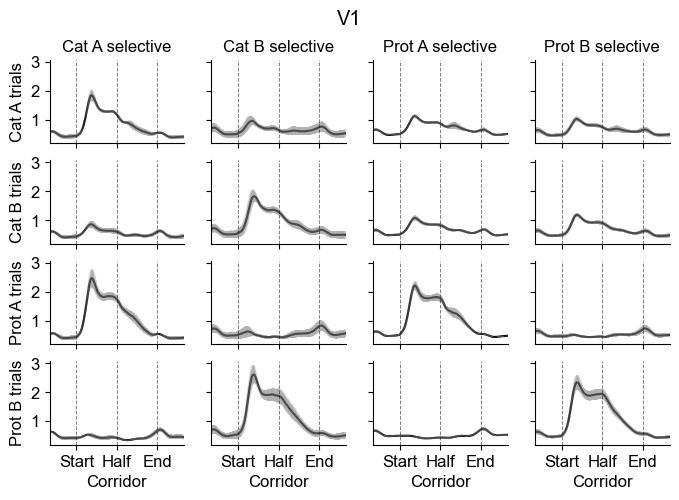

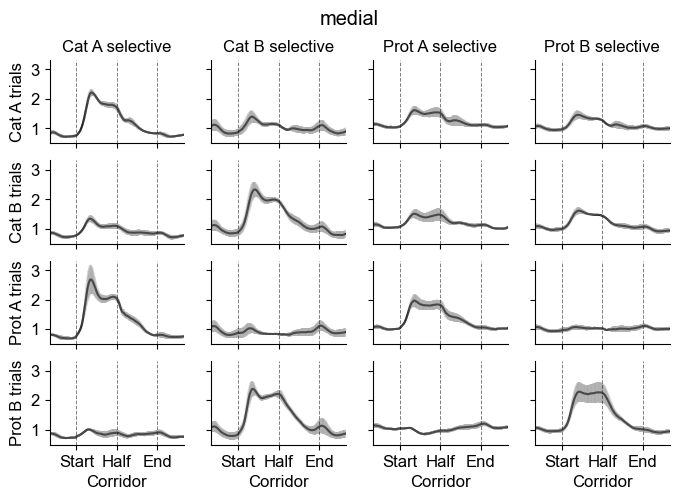

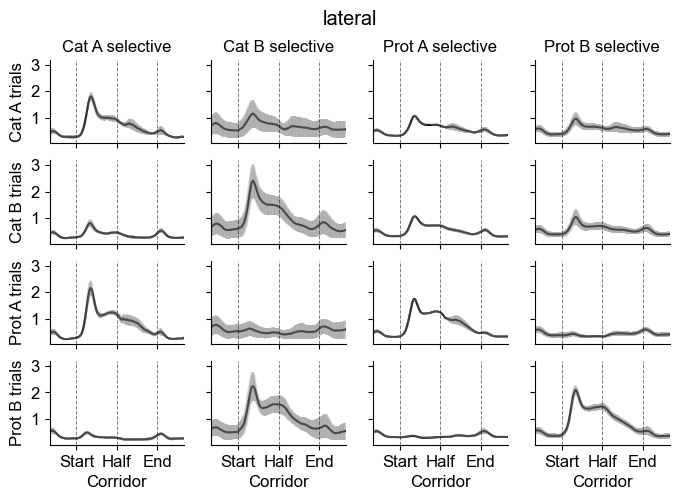

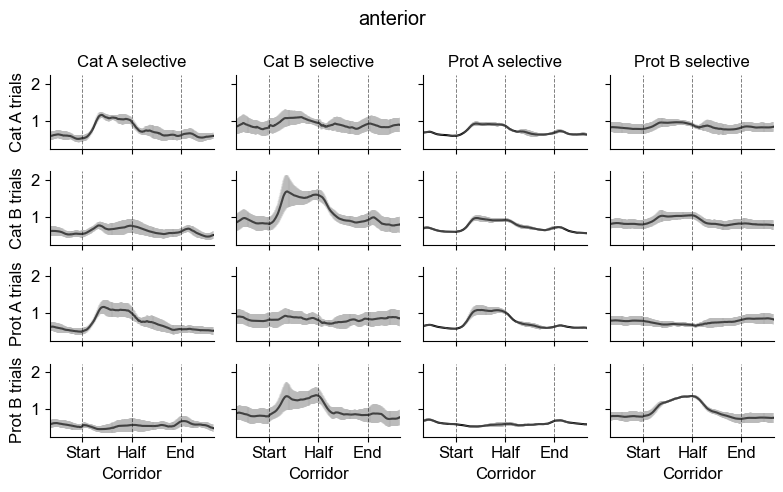

In [17]:
titles = ['Cat A selective', 'Cat B selective', 'Prot A selective', 'Prot B selective']
ylabels = ['Cat A trials', 'Cat B trials', 'Prot A trials', 'Prot B trials']
excitatory_res = pop_responses_mice
mean_mice = excitatory_res.mean(0)
sem_mice = sem(excitatory_res, axis=0)
for area in range(4):
    fig, ax = plt.subplots(4, 4, figsize=(8, 5), sharey=True, sharex=True)
    fig.suptitle(f'{areas[area]}', y=0.98)
    
    for sel in range(4):
        ax[0,sel].set_title(f'{titles[sel]}', loc='center', fontsize=default_font)
        for ttype in range(4):
            ax[ttype,0].set_ylabel(ylabels[ttype], rotation=90)
            ax[ttype,sel].plot(mean_mice[area,ttype,sel,:], color='k', linestyle='-')
            ax[ttype,sel].errorbar(np.arange(500), mean_mice[area,ttype,sel,:], yerr=sem_mice[area,ttype,sel,:], color="gray", linestyle='-', alpha = 0.1)
    for p in range(4):
        ax[-1,p].set_xlabel('Corridor')
        ax[-1,p].set_xticks([100, 250, 400], labels=["Start", "Half", "End"])
        for i in range(4):
            ax[i,p].axvline(x=0, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
            ax[i,p].axvline(x=100, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
            ax[i,p].axvline(x=250, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
            ax[i,p].axvline(x=400, color='k', linestyle='--', linewidth=0.7, alpha = 0.5)
            ax[i,p].set_xlim(0, 500)
plt.tight_layout()